XLM-RoBERTa 모델을 개체명 인식(NER)을 수행하도록 미세 튜닝하는 방법

참고하는 데이터 포멧 : https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)

In [34]:
!pip install datasets

In [35]:
from datasets import get_dataset_config_names
xtreme_subsets = get_dataset_config_names('xtreme')
len(xtreme_subsets)  # 서브셋 개수

183

In [36]:
 # Plagiarism Detection Across Languages  :  PAN-X  다양한 언어로 작성된 텍스트에서 표절 감지를 수행하기 위한 데이터
 panx_subsets =  [s for s in xtreme_subsets if s.startswith('PAN')]
 panx_subsets[:5]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de']

In [37]:
# 독일어 에 해당하는 코드를 전달
from datasets import load_dataset
load_dataset('xtreme', name = 'PAN-X.de')

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [38]:
# 스위스 말뭉치 = 스위스에서 사용되는 언어비율로 PAN-X 에서 독일어, 프랑스어 이탈리아어 영어 말뭉치를  샘플링
# 데이터가 불균형하게 만들어진다
# 각 언어를 추적하는  defaultdict 객체를 만든다 , 언어코드를 키로하고  DatasetDict 타입의 PAN-X말뭉치를 값으로 저장
from collections import defaultdict
from datasets import DatasetDict
langs = ['de','fr','it','en']
fracs = [0.629,0.228,0.084,0.059]

In [39]:
# 키가 없는경우 DatasetDict 를 반환
panx_ch = defaultdict(DatasetDict)
for lang,frac in zip(langs,fracs):
  # 다국어 말뭉치를 로드한다
  ds = load_dataset('xtreme', name=f"PAN-X.{lang}")
  # 각 분할을 언어 비율에 따라 다운셈플링하고 섞음
  for split in ds:
    panx_ch[lang][split] = (
        ds[split].shuffle(seed=0).select(range(int(frac*ds[split].num_rows)))
    )

In [40]:
# 데이터 확인
import pandas as pd
pd.DataFrame({lang: [ panx_ch[lang]['train'].num_rows] for lang in langs },index = ["Number of training examples"] )

,de,fr,it,en
Number of training examples,12580,4560,1680,1180


In [41]:
# 편향된 데이터를 가지고 제로샷 교차 언어 전이를 프랑스어, 이탈리아어, 영어에 수행
# 독일어 말뭉치 셈플을 확인
element =  panx_ch['de']['train'][0]
for key,value in element.items():
  print(f"{key} : {value}")

tokens : ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags : [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs : ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [42]:
for key, value in panx_ch['de']['train'].features.items():
  print(f"{key}:{value}")

tokens:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags:Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [43]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [44]:
def create_tag_names(batch):
  return{'ner_tags_str' : [ tags.int2str(idx) for idx in batch['ner_tags']] }

panx_de = panx_ch['de'].map(create_tag_names)
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [45]:
de_example =  panx_de['train'][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']],['Tokens','Tags'] )

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [46]:
# 개체명 빈도 계산
from collections import Counter
split2freqs = defaultdict(Counter)
for split,dataset in panx_de.items():
  for row in dataset['ner_tags_str']:
    for tag in row:
      if tag.startswith('B'):
        tag_type = tag.split('-')[1]
        split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient='index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [47]:
# 다중 언어 트랜스포머

In [48]:
# XLM-R 토큰화

In [49]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
bert_model_name = 'bert-base-cased'
xlmr_model_name = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [53]:
# 각 모델이 사용하는 특수 토큰을 확인
text = 'Jack Sparrow loves New York'
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [54]:
bert_tokens,xlmr_tokens

(['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '[SEP]'],
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '</s>'])

토큰화 파이프라인

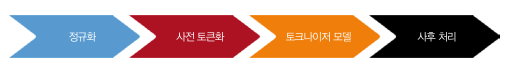

In [55]:
#  정규화
# 공백과 엑센트가 붙은 문자를 제거
# 유니코드 정규화   https://unicode.org/reports/tr15/  소문자로 변경
# 사전 토큰화 : 텍스트를 더 작은 객체로 분할
#   - 텍스트를 단어로 분할하고 최종 토큰은 이 단어의 일부가 된다 , 많은 언어 공백과 구두점을 기준으로 단어로 분할
# 사후처리 : 마지막 단계 , 처음과 끝에 특수문자를 추가할때

NER을 종종 토큰 분류 작업으로 생각 - 시퀀스 분류를 위해 인코더 기반 트랜스포머를 미세 튜닝

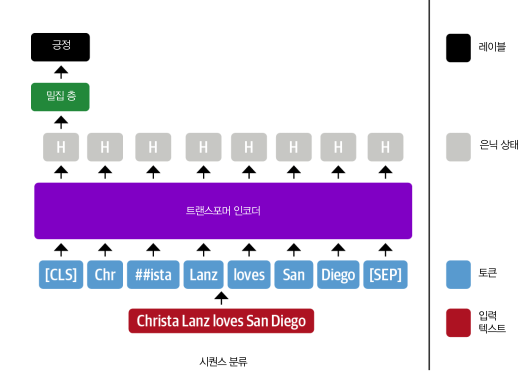

In [56]:
# 개체명 인식을 위해서 인코더 기반 트래스포머를 미세 튜닝

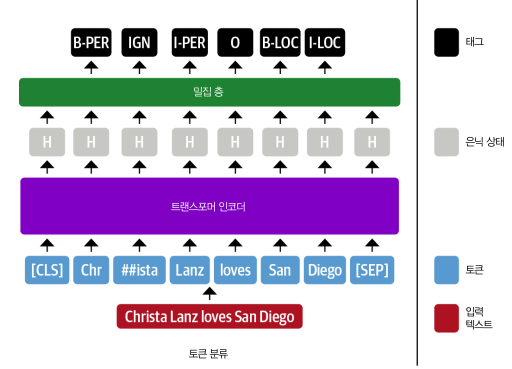

In [57]:
# XLM-R 클래스

In [59]:
import torch.nn as nn
from transformers import XLMRobertaConfig  # XLM-RoBERTa 모델의 설정을 정의하는 클래스
from transformers.modeling_outputs import TokenClassifierOutput # 토큰의 분류 작업을 위한 출력을 정의하는 클래스
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel
# RobertaPreTrainedModel  Hugging Face Transformers 의 라이브러리의 사전 훈련모델을 상속하는 클래스 -> 사용자 정의 지정 모델구축에 유용

In [60]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig
  def __init__(self, config):
    super(XLMRobertaForTokenClassification,self).__init__(config)
    self.num_labels = config.num_labels
    # 모델 바디를 로드
    self.roberta = RobertaModel(config,add_pooling_layer=False)
    # 토큰 분류 헤드를 준비
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    # 가중치를 로드하고 초기화
    self.init_weights()
  def forward(self,input_ids = None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    # 모델 바디를 사용해 인코더 표현을 구함
    outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids, **kwargs)
    # 인코더 표현을 헤드에 통과시킴
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    # 손실을 계산
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1,self.num_labels), labels.view(-1))
    # 모델 출력 객체를 반환
    return TokenClassifierOutput(loss=loss,logits=logits,hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [61]:
# 사용자 정의 모델 로드
index2tag = {idx:tag for idx,tag in enumerate(tags.names)}
tag2index = {tag:idx for idx,tag in enumerate(tags.names)}

In [62]:
from transformers import AutoConfig
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels = tags.num_classes,id2label=index2tag, label2id=tag2index)

In [ ]:
from torch.cuda import is_available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,config=xlmr_config).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]